In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clip

import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fontsize = 40
labelsize = 30

color_bl = '#648FFF' #blue
color_id = '#785EF0' #indigo
color_mg = '#DC267F' #magenta
color_or = '#FE6100' #orange

/tmp/ipykernel_26293/2864973888.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('jet')
/tmp/ipykernel_26293/2864973888.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm2 = plt.cm.get_cmap('rainbow')


In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

### Load data

In [180]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch-probgal&isoarea.csv", 
                    usecols=["ID", "RA", "DEC", "zml", "r_petro", "pdf_weights", "pdf_means", "pdf_stds"])

In [181]:
objid = np.array(table["ID"])
ra = table["RA"]
dec = table["DEC"]
zml = table["zml"]
rpetro = np.array(table["r_petro"])
weights = np.array(table["pdf_weights"])
means = np.array(table["pdf_means"]) 
stds = np.array(table["pdf_stds"])

In [64]:
table_specz = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch-probgal&isoarea-specz-crossmatch.csv", 
                    usecols=["ID", "RA_2", "DEC_2", "zml", "r_petro", "pdf_weights", "pdf_means", "pdf_stds", "z"])

In [65]:
objid_specz = np.array(table_specz["ID"])
ra_specz = table_specz["RA_2"]
dec_specz = table_specz["DEC_2"]
zml_specz = table_specz["zml"]
rpetro_specz = np.array(table_specz["r_petro"])
weights_specz = np.array(table_specz["pdf_weights"])
means_specz = np.array(table_specz["pdf_means"]) 
stds_specz = np.array(table_specz["pdf_stds"])
z = np.array(table_specz["z"])

In [8]:
#Clusters I selected to apply the membership method
# cl_names_mem = np.array(["Hydra", "Antlia", "AS0648", "AS0639", "A3443", "AS0630", "A3456", "AS0648"])
# cl_ra_mem = np.array([159.17417, 157.51461, 160.14115, 155.28746, 152.37918, 163.41456, 162.2862])
# cl_dec_mem = np.array([-27.52444, -35.32341, -46.19478, -33.71903, -33.67941, -32.39977, -42.84817])
# cl_z_mem = np.array([0.012, 0.009767, 0.057987, 0.0211, 0.0758, 0.068551, 0.113412, 0.057987])

cl_names_mem = np.array(["Hydra", "Antlia", "AS0648", "AS0639", "A3443"])
cl_ra_mem = np.array([159.17417, 157.51461, 162.2862, 160.14115, 155.28746])
cl_dec_mem = np.array([-27.52444, -35.32341, -42.84817, -46.19478, -33.71903])
cl_z_mem = np.array([0.012, 0.009767, 0.057987, 0.0211, 0.0758])

### Define some functions

In [9]:
def clustercentric_distance(ra, dec, ra0, dec0):
    '''
    Calculate the clustercentric distance of objects given their RA and DEC
    
    
    '''
    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
    
    
    sep = []
    for (i,j) in zip(ra,dec):
        c = SkyCoord(i*u.degree, j*u.degree)
        sep.append(c0.separation(c).degree) 
    sep = np.asarray(sep)
    return sep

[ 1.76886212e-04 -8.07438409e-03  1.23970821e-01 -6.33901493e-01]


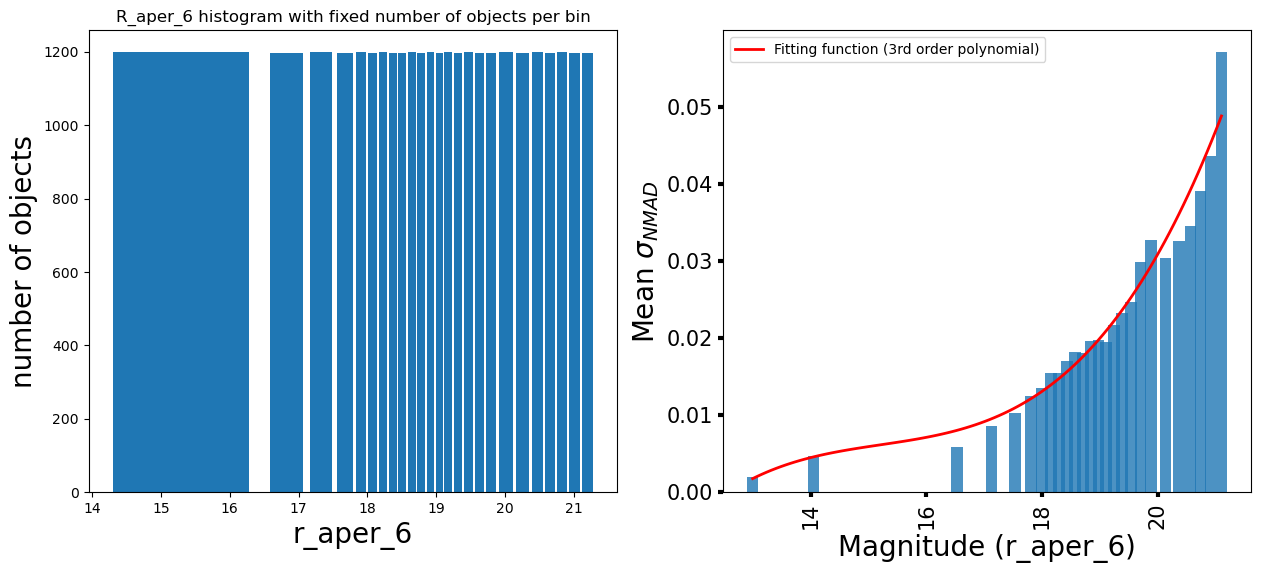

In [10]:
#Estimate sigma_nmad
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))


training_set = pd.read_csv("../CHANCES-target-selection/Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

rmag_train = training_set["r_aper_6"]
zml_train = training_set["zml"]
z_train = training_set["z"]


fontsize=20
labelsize=15
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)

n, bins, patches = ax1.hist(rmag_train, histedges_equalN(rmag_train, 25), histtype='bar', rwidth=0.8)
ax1.set_xlabel("r_aper_6", fontsize=fontsize)
ax1.set_ylabel("number of objects", fontsize=fontsize)
ax1.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize*0.6)


mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask_i = (rmag_train > mag[i-1]) & (rmag_train < mag[i])
    delta_z_i = zml_train[mask_i] - z_train[mask_i]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z_i - np.median(delta_z_i)) / (1 + z_train[mask_i]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

    
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)
print(popt1)

ax2 = fig.add_subplot(122)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax2.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax2.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax2.set_xlabel("Magnitude (r_aper_6)", fontsize=fontsize)
ax2.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, rotation=90)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax2.legend()
    

def sigma_nmad(r):
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
    return sigma_nmad

In [11]:
# Calc_PDF_series
def calc_PDF_series(weights, means, stds, x_range=None, optimize_zml=False):
    '''
    Returns a list of PDFs calculated as a combination of Gaussian functions

    Keyword arguments:
    x            -- Photometric redshift range for which the PDF should be calculated
    weights      -- Weight of the Gaussian components
    means        -- means of the Gaussian components
    stds         -- Standard deviation of the Gaussian components
    optimize_zml -- If the single-point estimate of photometric redshift should be optimized (if True, it will be
                    determined on a finer grid of points)
    '''
    
    if x_range is None:
        x = np.arange(-0.005, 1+0.001, 0.001) 
    else:
        x = x_range
                      
    # Convert columns from string to lists
    if type(weights) != np.ndarray:
        weights = np.array(weights)
        means   = np.array(means)
        stds    = np.array(stds)

    # Calculating PDFs and optimizing photo-zs (optional)
    PDFs           = []
    optimized_zmls = np.empty(len(means))
    
    if np.ndim(weights) == 2: # weights, means, and stds are 2D arrays 
        for i in range(len(weights)):
            PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            PDF = PDF/np.trapz(PDF, x)
            PDFs.append(PDF)
        zmls = x[np.argmax(PDFs, axis=1)]
        
    if np.ndim(weights) == 1:
        PDF  = np.sum(weights*(1/(stds*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means)**2)/(stds)**2), axis=1)
        PDFs = PDF/np.trapz(PDF, x)
        zmls = x[np.argmax(PDFs)]

    if optimize_zml == True:
        for i in range(len(weights)):
            # First run
            optimized_x   = np.linspace(zmls[i]-0.002, zmls[i]+0.002, 500, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zml = optimized_x[np.argmax(optimized_PDF)]

            # Second run
            optimized_x   = np.linspace(optimized_zml-0.001, optimized_zml+0.001, 300, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zmls[i] = optimized_x[np.argmax(optimized_PDF)]

        zmls = optimized_zmls
                
    return PDFs, zmls, x

In [51]:
def P_pz(i, zagl, means, weights, stds, rmag):
    
    sigma = sigma_nmad(rmag[i])
    
    means = np.array([float(_) for _ in means[i].split(',')])
    weights = np.array([float(_) for _ in weights[i].split(',')])
    stds = np.array([float(_) for _ in stds[i].split(',')])

    pdfs, zmls, x = calc_PDF_series(weights, means, stds) 
    
    pdfs_interp = interp1d(x, pdfs)
    a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]

    pdf_func = lambda x: a * pdfs_interp(x)
        
    
    def gaussian(x, zagl, sigma):
        y = lambda x, zagl, sigma: (1 / sigma * np.sqrt(2* np.pi)) * np.exp(-(x - zagl)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zagl, sigma))[0]
        return a * y(x, zagl, sigma)
    
     
    if zagl - 3*sigma <= 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), 0.0, zagl + 3*sigma, args=(sigma))[0]
        
    if zagl - 3*sigma > 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma))[0]
        
    return P_pz_G, P_pz_F

In [59]:
def sigma_clipping(z_spec, ids, zlower, zupper, sigma):
    '''
    Perform a cluster spectroscopic membership using sigma clipping
    '''
    # It is necessary to restrict a little the sample.  We have to look at this cluster by cluster
    cluster_max_cut = (z_spec > zlower) & (z_spec < zupper)

    cluster_sig = sigma_clip(z_spec[cluster_max_cut], sigma=sigma, cenfunc='median', stdfunc='mad_std') 

    # Objects selected after applying the 3sigmaclipping cut
    specz_members = z_spec[cluster_max_cut][~cluster_sig.mask]
    id_members = ids[cluster_max_cut][~cluster_sig.mask]
    
    return specz_members, id_members

### Look at the clusters one by one

In [197]:
sep = np.array([clustercentric_distance(ra_specz, dec_specz, ra0, dec0) for ra0, dec0 in zip(cl_ra_mem, cl_dec_mem)])

In [198]:
#I will use 0.5 (deg) as the radius for all clusters, except Hydra, which has radius = 1.5744
cluster = 4

radius_cluster = 0.5
z_cluster = cl_z_mem[cluster]
ra0 = cl_ra_mem[cluster]
dec0 = cl_dec_mem[cluster]

mask_cluster = sep[cluster] < 5*radius_cluster

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


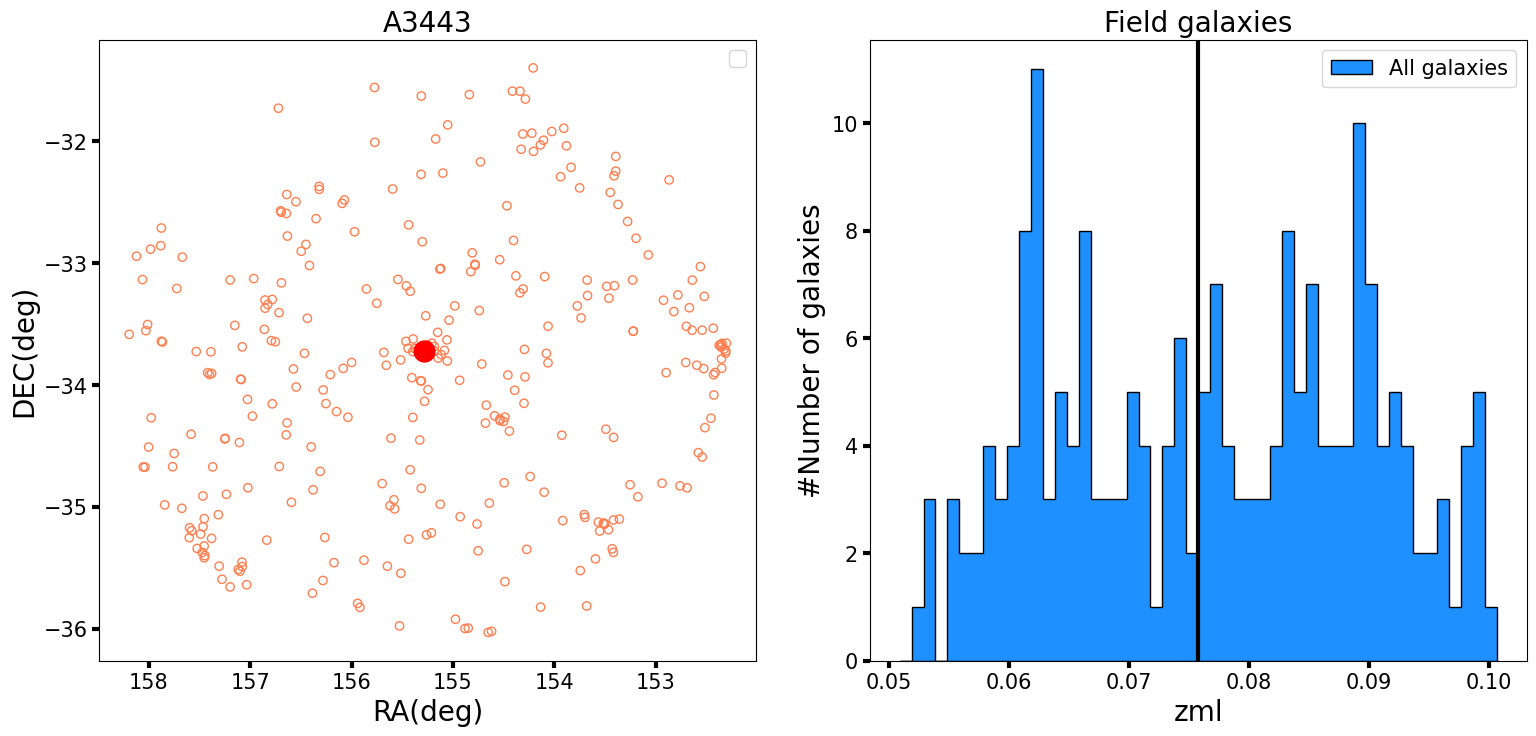

In [153]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(ra_specz[mask_cluster], dec_specz[mask_cluster], marker='o', color='coral', facecolor='none')
ax1.plot(ra0, dec0, 'o', color="red", markersize=15)
ax1.set_xlabel('RA(deg)',fontsize=fontsize)
ax1.set_ylabel('DEC(deg)',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)
ax1.invert_xaxis()
ax1.set_title(cl_names_mem[cluster], fontsize=fontsize)


ax2 = fig.add_subplot(122)
ax2.hist(zml_specz[mask_cluster], bins=50, color="dodgerblue", histtype="stepfilled", edgecolor="black", 
                 label="All galaxies", range=[z_lower, z_upper])
ax2.set_xlabel('zml',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)
ax2.set_title("Field galaxies", fontsize=fontsize)
ax2.axvline(z_cluster, color='black', lw=3)


fig.tight_layout(pad=3.0)

plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/RA_DEC_zml_distribution_{}.pdf".format(cl_names_mem[cluster]), dpi='figure', format='pdf')

In [ ]:
#A3456 --> redshift mais alto do que os que photo-zs que eu tenho na minha tabela do Hydra Supercluster
#AS0639 --> very weird distribution of photo-zs (no peak)
#A3443 --> no apparent peak in the distribution of photo-zs
#AS0630 --> it is hard to see a concentration of galaxies where the cluster was supposed to be

### Calculate priors

In [199]:
sigma_z = np.array([sigma_nmad(r) for r in rpetro_specz[mask_cluster]])

sigma = np.median(sigma_z)
z_lower = z_cluster-3*sigma
z_upper = z_cluster+3*sigma

In [200]:
#Create a mask to select candidate field galaxies
Rlim = 5*radius_cluster
Ragl = 3*radius_cluster
f_field = 5.0
f_cluster = 3.0

mask_field = (sep[cluster][mask_cluster] > Ragl) & (sep[cluster][mask_cluster] < Rlim) & ((zml_specz[mask_cluster] 
                    < (z_cluster - f_field*sigma_z)) | (zml_specz[mask_cluster] > (z_cluster + f_field*sigma_z)))

In [201]:
#The photo-zs are between 0.0 and 0.1, so to calculate the field volume we have to make sure we are considering the
#correct intervals in photo-z. Remember we are calculating the volume of a cylinder divided in two parts, so
#we have to sum them (the one from 0 to z_cluster - f*sigma and the other from z_cluster + f*sigma to 0.1).

if ((z_cluster - f_field*sigma) > 0) & ((z_cluster + f_field*sigma) < 0.1): 
    volume_field = np.pi * (Rlim**2 - Ragl**2) * ((z_cluster - f_field*sigma) + (0.1 - (z_cluster + f_field*sigma)))
    
elif ((z_cluster - f_field*sigma) > 0) & ((z_cluster + f_field*sigma) > 0.1):
    volume_field = np.pi * (Rlim**2 - Ragl**2) * (z_cluster - f_field*sigma)
    
elif ((z_cluster - f_field*sigma) < 0) & ((z_cluster + f_field*sigma) < 0.1):
    volume_field = np.pi * (Rlim**2 - Ragl**2) * (0.1 - (z_cluster + f_field*sigma))
    
elif ((z_cluster - f_field*sigma) < 0) & ((z_cluster + f_field*sigma) > 0.1):
    volume_field = 0
    
    
n_F = np.sum(mask_field) / volume_field

N_F = n_F * np.pi * Ragl**2 * ((z_cluster + f_cluster*sigma) - (z_cluster - f_cluster*sigma))
print("Number of field galaxies in the region of the cluster by computing first the density n_F: {:.2f}".format(N_F))

Number of field galaxies in the region of the cluster by computing first the density n_F: 44.73


In [202]:
mask_tot = (sep[cluster] < Ragl) & ((zml_specz > (z_cluster - f_cluster*sigma)) 
                                        | (zml_specz < (z_cluster + f_cluster*sigma)))
N_tot = np.sum(mask_tot)
print("Total number of galaxies in the region of the cluster: {:.2f}".format(N_tot))

P_ginF = N_F / N_tot
print("Prior P(g in F): {:.2f}".format(P_ginF))

P_ginG = 1 - P_ginF
print("Prior P(g in G): {:.2f}".format(P_ginG))

Total number of galaxies in the region of the cluster: 127.00
Prior P(g in F): 0.35
Prior P(g in G): 0.65


### Look at the clusters one by one (photometric)

In [183]:
sep_all = np.array([clustercentric_distance(ra, dec, ra0, dec0) for ra0, dec0 in zip(cl_ra_mem, cl_dec_mem)])

In [203]:
#I will use 0.5 (deg) as the radius for all clusters, except Hydra, which has radius = 1.5744
cluster = 4

radius_cluster = 0.5
z_cluster = cl_z_mem[cluster]
ra0 = cl_ra_mem[cluster]
dec0 = cl_dec_mem[cluster]

mask_cluster = sep_all[cluster] < 5*radius_cluster

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


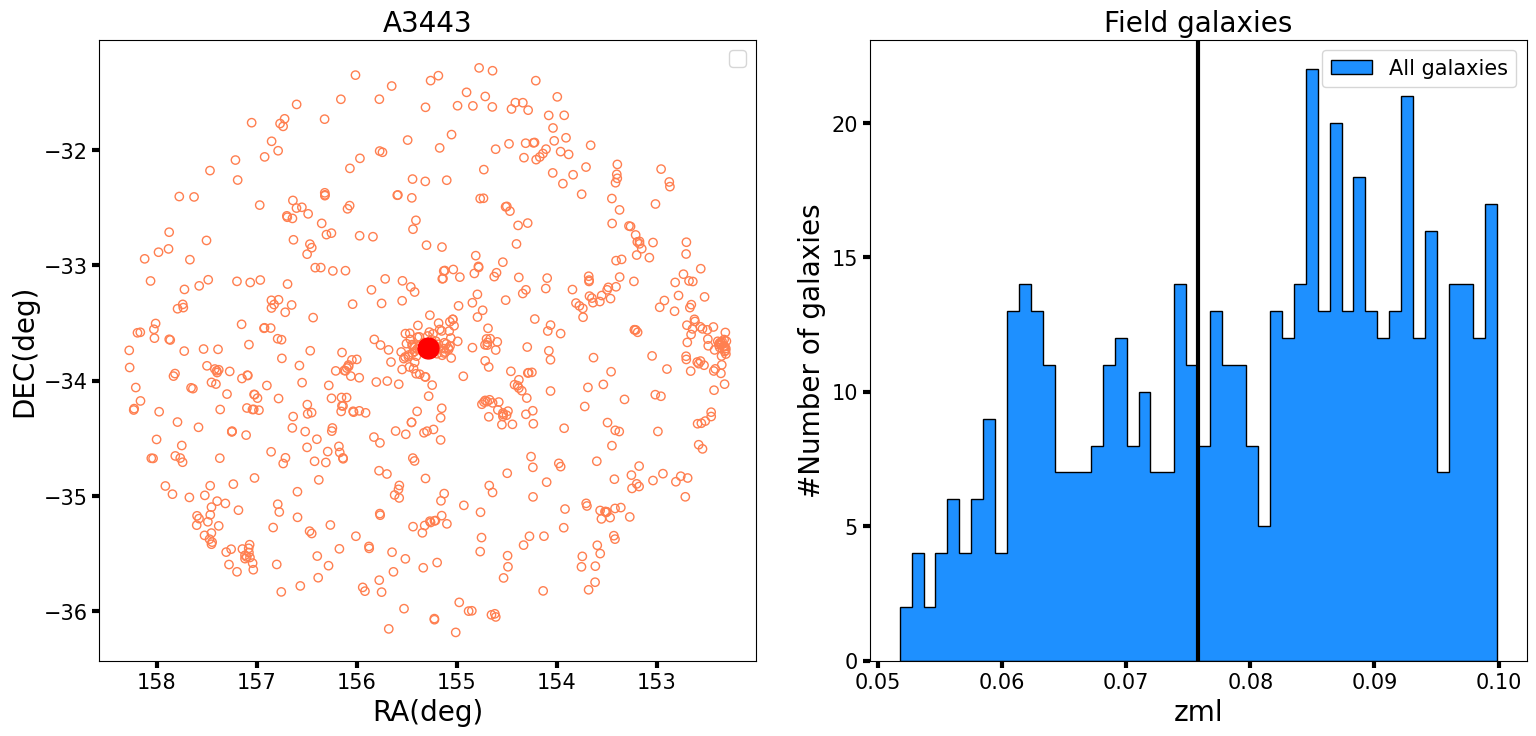

In [185]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(ra[mask_cluster], dec[mask_cluster], marker='o', color='coral', facecolor='none')
ax1.plot(ra0, dec0, 'o', color="red", markersize=15)
ax1.set_xlabel('RA(deg)',fontsize=fontsize)
ax1.set_ylabel('DEC(deg)',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)
ax1.invert_xaxis()
ax1.set_title(cl_names_mem[cluster], fontsize=fontsize)


ax2 = fig.add_subplot(122)
ax2.hist(zml[mask_cluster], bins=50, color="dodgerblue", histtype="stepfilled", edgecolor="black", 
                 label="All galaxies", range=[z_lower, z_upper])
ax2.set_xlabel('zml',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)
ax2.set_title("Field galaxies", fontsize=fontsize)
ax2.axvline(z_cluster, color='black', lw=3)


fig.tight_layout(pad=3.0)

plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/RA_DEC_zml_distribution_all_{}.pdf".format(cl_names_mem[cluster]), dpi='figure', format='pdf')

### Calculate priors

In [204]:
sigma_z = np.array([sigma_nmad(r) for r in rpetro[mask_cluster]])

sigma = np.median(sigma_z)
z_lower = z_cluster-3*sigma
z_upper = z_cluster+3*sigma

In [205]:
#Create a mask to select candidate field galaxies
Rlim = 5*radius_cluster
Ragl = 3*radius_cluster
f_field = 5.0
f_cluster = 3.0

mask_field = (sep_all[cluster][mask_cluster] > Ragl) & (sep_all[cluster][mask_cluster] < Rlim) & ((zml[mask_cluster] 
                    < (z_cluster - f_field*sigma_z)) | (zml[mask_cluster] > (z_cluster + f_field*sigma_z)))

In [206]:
if ((z_cluster - f_field*sigma) > 0) & ((z_cluster + f_field*sigma) < 0.1): 
    volume_field = np.pi * (Rlim**2 - Ragl**2) * ((z_cluster - f_field*sigma) + (0.1 - (z_cluster + f_field*sigma)))
    
elif ((z_cluster - f_field*sigma) > 0) & ((z_cluster + f_field*sigma) > 0.1):
    volume_field = np.pi * (Rlim**2 - Ragl**2) * (z_cluster - f_field*sigma)
    
elif ((z_cluster - f_field*sigma) < 0) & ((z_cluster + f_field*sigma) < 0.1):
    volume_field = np.pi * (Rlim**2 - Ragl**2) * (0.1 - (z_cluster + f_field*sigma))
    
elif ((z_cluster - f_field*sigma) < 0) & ((z_cluster + f_field*sigma) > 0.1):
    volume_field = 0
    
    
n_F = np.sum(mask_field) / volume_field

N_F = n_F * np.pi * Ragl**2 * ((z_cluster + f_cluster*sigma) - (z_cluster - f_cluster*sigma))
print("Number of field galaxies in the region of the cluster by computing first the density n_F: {:.2f}".format(N_F))

Number of field galaxies in the region of the cluster by computing first the density n_F: 67.58


In [207]:
mask_tot = (sep_all[cluster] < Ragl) & ((zml > (z_cluster - f_cluster*sigma)) 
                                        | (zml < (z_cluster + f_cluster*sigma)))
N_tot = np.sum(mask_tot)
print("Total number of galaxies in the region of the cluster: {:.2f}".format(N_tot))

P_ginF = N_F / N_tot
print("Prior P(g in F): {:.2f}".format(P_ginF))

P_ginG = 1 - P_ginF
print("Prior P(g in G): {:.2f}".format(P_ginG))

Total number of galaxies in the region of the cluster: 305.00
Prior P(g in F): 0.22
Prior P(g in G): 0.78


In [ ]:
#I think it would be at least reasonable to use the same prior for the spectroscopic and photometric steps of the membership

### Perform the membership calculation

In [159]:
Pmem = np.zeros(len(zml_specz[mask_cluster]))
for i in range(len(zml_specz[mask_cluster])):  
    P_pz_G_i, P_pz_F_i = P_pz(i, z_cluster, means_specz[mask_cluster],
                                  weights_specz[mask_cluster], stds_specz[mask_cluster], rpetro_specz[mask_cluster])
    Pmem[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

/tmp/ipykernel_26293/1285968684.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_26293/1285968684.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a 

### Perform sigma clipping to calculate purity and completeness and select a cut

In [160]:
z_members, id_members = sigma_clipping(z[mask_cluster], objid_specz[mask_cluster], z_lower, z_upper, 3)
mask_members = np.isin(objid_specz[mask_cluster], id_members)

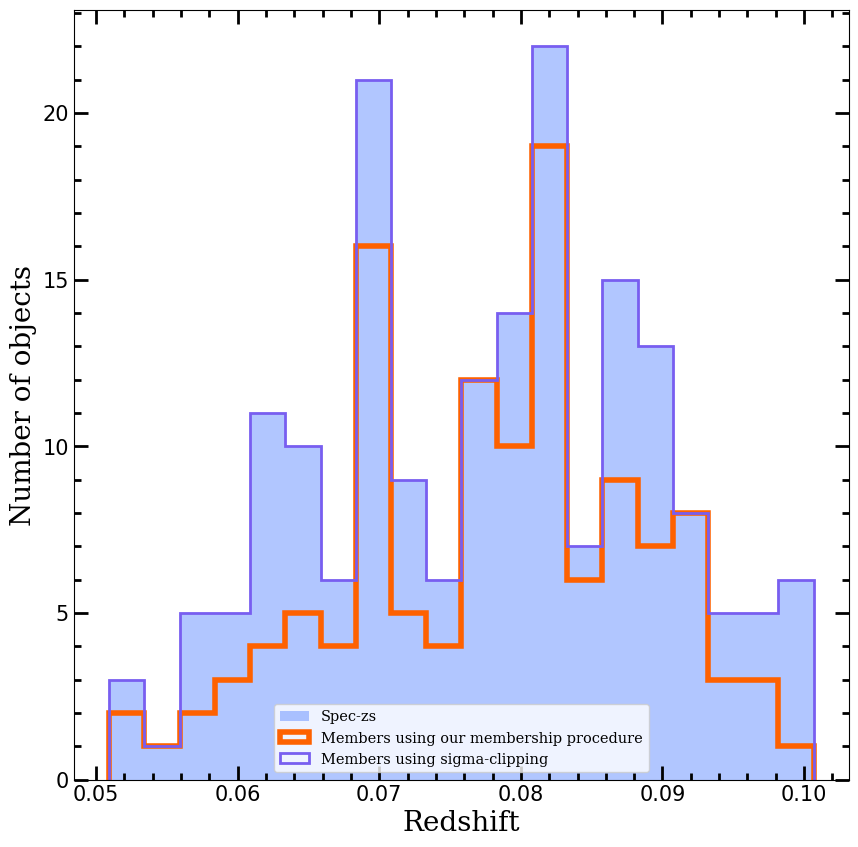

In [169]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

c = 0.59
bins = 20
ax.hist(z[mask_cluster], alpha=0.5, label='Spec-zs', bins=bins, range=(z_lower, z_upper), histtype='stepfilled', color=color_bl)
ax.hist(z[mask_cluster][Pmem > c], alpha=1.0, label='Members using our membership procedure', bins=bins, range=(z_lower, z_upper), histtype='step', lw=4, color=color_or)
ax.hist(z_members, alpha=1.0, label='Members using sigma-clipping', bins=bins, range=(z_lower, z_upper), histtype='step', lw=2, color=color_id)
# ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Redshift", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.7,'family':'serif'})
lg.draw_frame(True)

plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/specz_distribution_sigma_clipping_membership_{}.pdf".format(cl_names_mem[cluster]), dpi='figure', format='pdf')

In [162]:
completeness = []
purity = []
d = 0.005
crit = np.arange(0.5, 0.95, d)

for c in crit:
    completeness.append(np.sum((Pmem > c) & mask_members) / np.sum(mask_members))
    purity.append(np.sum(mask_members & (Pmem > c)) / np.sum((Pmem > c)))

/tmp/ipykernel_26293/2958991267.py:8: RuntimeWarning: invalid value encountered in scalar divide
  purity.append(np.sum(mask_members & (Pmem > c)) / np.sum((Pmem > c)))


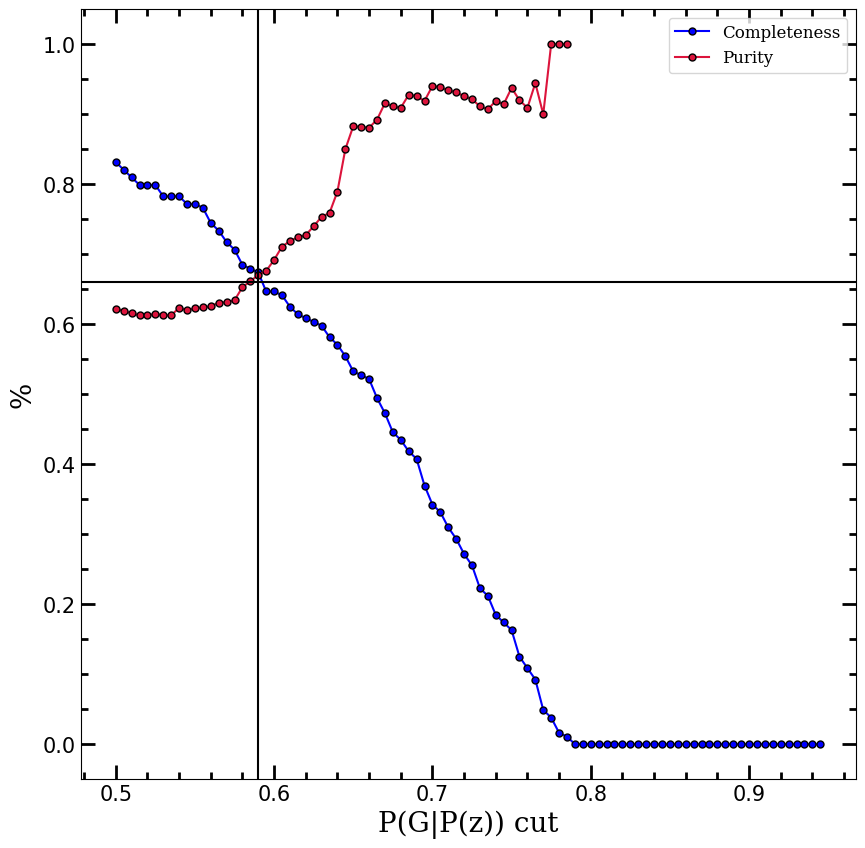

In [166]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax1 = fig.add_subplot(111)

ms = 5
ax1.plot(crit, completeness, marker='o', color="blue", markerfacecolor="blue", label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color="crimson", markerfacecolor="crimson", label="Purity", markersize=ms, markeredgecolor="black")

# ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
# ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=7)

ax1.set_ylabel("%", fontsize=fontsize, family='serif')
ax1.set_xlabel("P(G|P(z)) cut", fontsize=fontsize, family='serif')
# ax1.set_title("Membership probability purity and completeness", fontsize=fontsize, family='serif')
ax1.legend(fontsize=13)

tick_color = 'black'
ax1.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax1.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax1.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.8,'family':'serif'})
lg.draw_frame(True)

ax1.axvline(0.59, color="black")
ax1.axhline(0.66, color="black")
plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/membership_probability_purity_completeness_{}.pdf".format(cl_names_mem[cluster]), dpi='figure', format='pdf')

In [ ]:
#For some of the clisters the membership got a little chaotic. Maybe I should try others values for the cut in sigma
#like 2sigma instead of 3 when selecting clusters potential members. But in general the membership is looking good.
#Nest step is apply it for all (photometric) objects when save the results in a table for each cluster. 
#This will be used afterwards for the membership of all the supercluster.

## Now we do the same but for all (photometric) objects 

### Perform the membership calculation

In [191]:
Pmem_all = np.zeros(len(zml[mask_cluster]))
for i in range(len(zml[mask_cluster])):  
    P_pz_G_i, P_pz_F_i = P_pz(i, z_cluster, means[mask_cluster],
                                  weights[mask_cluster], stds[mask_cluster], rpetro[mask_cluster])
    Pmem_all[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

/tmp/ipykernel_26293/1285968684.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_26293/1285968684.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a 

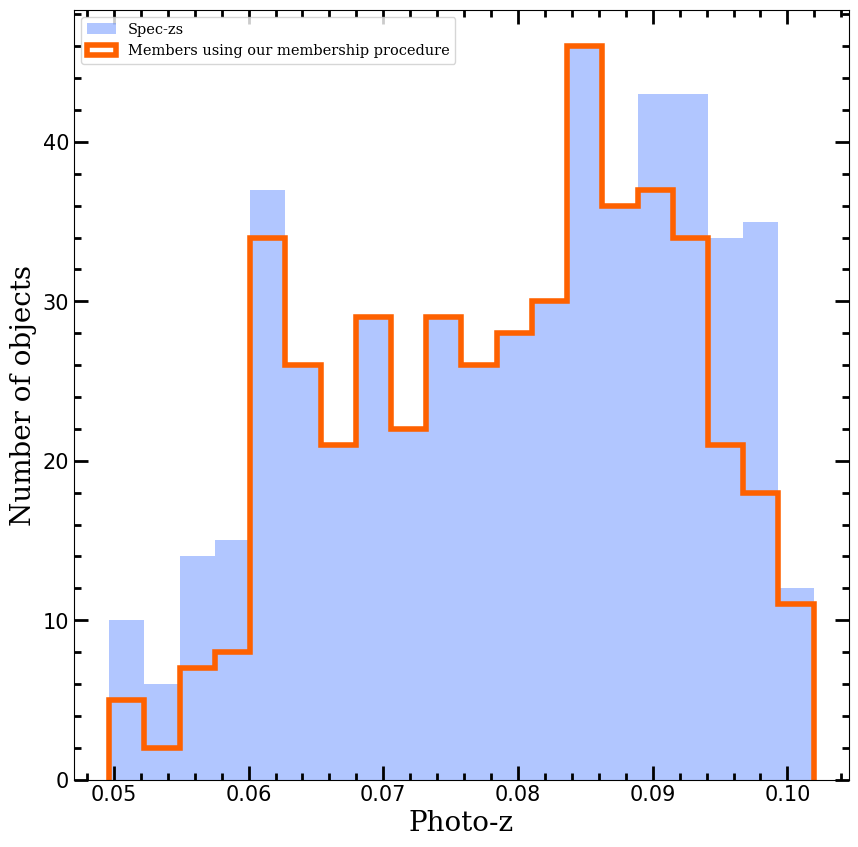

In [194]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

c = 0.7
bins = 20
ax.hist(zml[mask_cluster], alpha=0.5, label='Spec-zs', bins=bins, range=(z_lower, z_upper), histtype='stepfilled', color=color_bl)
ax.hist(zml[mask_cluster][Pmem_all > c], alpha=1.0, label='Members using our membership procedure', bins=bins, range=(z_lower, z_upper), histtype='step', lw=4, color=color_or)
# ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Photo-z", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.7,'family':'serif'})
lg.draw_frame(True)

# plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/specz_distribution_sigma_clipping_membership_{}.pdf".format(cl_names_mem[cluster]), dpi='figure', format='pdf')